In [1]:
# BASED ON predict_listener_histatt_TEST.py

In [2]:
import torch
import numpy as np
import json
import os

from listener.models.model_bert_att_ctx_hist import ListenerModelBertAttCtxHist

# !!!!!!!!!!!!!!!!!!!!
# PLEASE NOTE THAT WE ARE USING THE DEMO DATASET HERE TO PRINT OUT
# CHAIN HISTORIES IN TEXTUAL FORMAT
# IN THE ACTUAL CODE, WE USE THE REPRESENTATIONS OF THE HISTORIES
# !!!!!!!!!!!!!!!!!!!!

from listener.utils.ListenerDatasetBertDemo import ListenerDataset


from transformers import BertTokenizer, BertModel

PyTorch version 1.6.0 available.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [4]:
def mask_attn(actual_num_tokens, max_num_tokens, device):

    masks = []

    for n in range(len(actual_num_tokens)):

        # items to be masked are TRUE
        mask = [False] * actual_num_tokens[n] + [True] * (max_num_tokens - actual_num_tokens[n])
        masks.append(mask)

    masks = torch.tensor(masks).unsqueeze(2).to(device)

    return masks

In [5]:
def get_bert_outputs(text, model, tokenizer):

    input_tensors = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    # same as adding special tokens then tokenize + convert_tokens_to_ids

    # reference resolution uses [CLS] AND [SEP] remove [EOS] from hypotheses of the generation models
    tokenized_text = tokenizer.tokenize('[CLS]' + text + '[SEP]')
    # input tensors the same as tokenizer.convert_tokens_to_ids(tokenized_text)

    #print(input_tensors)

    # just one segment
    segments_ids = [0] * input_tensors.shape[1]
    segments_tensors = torch.tensor([segments_ids])

    input_tensors = input_tensors.to(device)
    segments_tensors = segments_tensors.to(device)

    # Predict hidden states features for each layer
    with torch.no_grad():
        # See the models docstrings for the detail of the inputs
        outputs = model(input_tensors, token_type_ids=segments_tensors)

        # Transformers models always output tuples.
        # See the models docstrings for the detail of all the outputs
        # In our case, the first element is the hidden state of the last layer of the Bert model

        encoded_layers = outputs[0]
    # We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)
    assert tuple(encoded_layers.shape) == (1,  input_tensors.shape[1], model.config.hidden_size)
    assert len(tokenized_text) == input_tensors.shape[1]

    return encoded_layers, tokenized_text

In [6]:
def evaluate_trained_model(split_data_loader, split_dataset, model, device, hyps, model_bert, 
                           tokenizer, index, input_hypothesis):

    with open('coco_id2file.json', 'r') as f:
        id2file = json.load(f)

    for ii, data in enumerate(split_data_loader):
        
        if ii == index:
            
            print('Data index =', ii)
            
            hypothesis = input_hypothesis

            #hypothesis = ' '.join([w for w in hyps[ii].split() if w != '<eos>'])
            utterances_BERT = get_bert_outputs(hypothesis, model_bert, tokenizer)[0]

            image_set = data['image_set'][0] # shape (1,6)
            target = data['target']

            target_img = image_set[target].item()

            # image files can be downloaded from
            # https://dmg-photobook.github.io/downloads.html 
            # Image sets https://github.com/dmg-photobook/photobook_dataset/raw/master/images.zip

            # but they are separated per domain
            # I created one folder with all images directly under it

            # you can use to map the image ID as returned in data to the actual file name
            # with coco_id2file.json

            rcParams['figure.figsize'] = 20, 20
            fig = plt.figure()


            for s in range(len(image_set)):

                img_id_no = str(image_set[s].item())

                candidate = mpimg.imread(os.path.join('photobook_coco_images/images', id2file[img_id_no]))

                ax = fig.add_subplot(1, 6, s + 1)

                plt.title(str(s) + ' - ' + img_id_no)

                plt.axis('off')
                imgplot = plt.imshow(candidate)            

            print('Hypothesis:', hypothesis, '\n')
            print('Target:', target.item(), '(', target_img, ')', '\n')

            print('Candidate histories')
            demo_histories = data['DEMO_histories'][0]  # batch size is 1

            for dh in range(len(demo_histories)):
                print(dh, ' '.join(demo_histories[dh]))
                
            print()

            context_separate = data['separate_images']
            context_concat = data['concat_context']

            lengths = [utterances_BERT.shape[1]]
            targets = data['target']

            max_length_tensor = utterances_BERT.shape[1]

            masks = mask_attn(lengths, max_length_tensor, device)

            prev_hist = data['prev_histories']

            out = model(utterances_BERT, lengths, context_separate, context_concat, prev_hist, masks, device)

            preds = torch.argmax(out, dim=1)

            print('Prediction:', preds.item(), '(', image_set[preds.item()].item(), ')')

            break

listener/saved_models/model_listener_NEW_bert_att_ctx_hist_base_CE_3_accs_2020-05-19-0-38-21.pkl
0.8595649392194498
Namespace(attention_dim=512, batch_size=32, bert_type='base', breaking=False, data_path='./data', dropout_prob=0.5, hidden_dim=512, learning_rate=0.0001, metric='accs', model_type='bert_att_ctx_hist', reduction='sum', seed=3, shuffle=True, subset_size=-1, vectors_file='vectors.json')
seed 28
FINAL_SPEAKERS/TEST_JSONS/histatt/hyps_hist_att_bert_test_2020-05-26-21-17-19.json
processing test
test len 6155
test

Data index = 25
Hypothesis:  

Target: 5 ( 100022 ) 

Candidate histories
0 
1 
2 
3 
4 i have broccoli and other vegetables on a square white plate .
5 

Prediction: 4 ( 492731 )


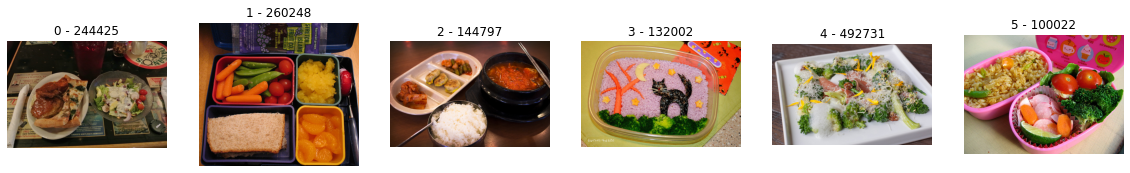

In [7]:
if __name__ == '__main__':

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # ALREADY do_lower_case=True

    # Load pre-trained model (weights)
    model_bert = BertModel.from_pretrained('bert-base-uncased')

    # Set the model in evaluation mode to deactivate the DropOut modules
    # This is IMPORTANT to have reproducible results during evaluation!
    model_bert.eval()
    model_bert.to(device)

    model_file = 'listener/saved_models/model_listener_NEW_bert_att_ctx_hist_base_CE_3_accs_2020-05-19-0-38-21.pkl'
    print(model_file)

    checkpoint = torch.load(model_file, map_location=device)

    print(checkpoint['accuracy'])

    args = checkpoint['args']
    print(args)

    model_type = args.model_type
    bert_type = args.bert_type

    all_hyps_files = ['FINAL_SPEAKERS/TEST_JSONS/histatt/hyps_hist_att_bert_test_2020-05-26-21-17-19.json']
#     ,
#                       'FINAL_SPEAKERS/TEST_JSONS/histatt/hyps_hist_att_bert_test_2020-05-26-21-21-18.json',
#                       'FINAL_SPEAKERS/TEST_JSONS/histatt/hyps_hist_att_bert_test_2020-05-26-21-24-48.json',
#                       'FINAL_SPEAKERS/TEST_JSONS/histatt/hyps_hist_att_bert_test_2020-05-26-21-28-2.json',
#                       'FINAL_SPEAKERS/TEST_JSONS/histatt/hyps_hist_att_bert_test_2020-05-26-21-31-21.json']

    for hyps_file_path in all_hyps_files:

        for seed in [28]:

            print('seed', seed)
            # for reproducibilty
            torch.manual_seed(seed)
            np.random.seed(seed)
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

            print(hyps_file_path)

            with open(hyps_file_path, 'r') as f:
                hyps = json.load(f)

            testset = ListenerDataset(
                data_dir='listener/data',
                utterances_file='test_BERTNEW_utterances.pickle',
                representations_file='test_BERTNEW_representations.pickle',
                vectors_file='vectors.json',
                chain_file='test_BERTNEW_chains.json',
                split='test',
                subset_size=-1
            )

            load_params_test = {'batch_size': 1, 'shuffle': False,
                                'collate_fn': ListenerDataset.get_collate_fn(device)}

            test_loader = torch.utils.data.DataLoader(testset, **load_params_test)

            print('test len', len(testset))

            img_dim = 2048
            hidden_dim = args.hidden_dim
            att_dim = args.attention_dim

            dropout_prob = args.dropout_prob

            if bert_type == 'base':

                embedding_dim = 768

            elif bert_type == 'large':

                embedding_dim = 1024

            # depending on the selected model type, we will have a different architecture

            if model_type == 'bert_att_ctx_hist': # BERT as embeds, vis context given with BERT embeds together, history added to the target side?

                model = ListenerModelBertAttCtxHist(embedding_dim, hidden_dim, img_dim, att_dim, dropout_prob) #.to(device)

            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)

            with torch.no_grad():

                model.eval()

                print('test\n')
                
                input_index = 25
                input_hyp = ''
        
                evaluate_trained_model(test_loader, testset, model, device, hyps,
                                     model_bert, tokenizer, input_index, input_hyp)

Data index = 500
Hypothesis: little child celebrating his birthday 

Target: 4 ( 126144 ) 

Candidate histories
0 
1 my last one is the birthday cake with the lit candles , white with pink and green
2 
3 
4 i have a picture of a small child ready to touch a birthday cake .
5 

Prediction: 4 ( 126144 )


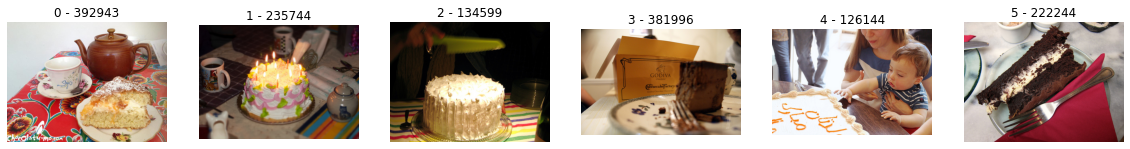

In [13]:
# TRY OUT THE RESOLUTION MODEL YOURSELF

input_index = 500
input_hyp = 'little child celebrating his birthday'
evaluate_trained_model(test_loader, testset, model, device, hyps,
                                     model_bert, tokenizer, input_index, input_hyp)